In [103]:
import os
import glob
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
from tqdm.auto import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
num_workers = 0
batch_size = 1
k = 5                # num k-folds
seed = 88
random.seed(seed)
torch.manual_seed(seed)

In [2]:
print(torch.cuda.is_available())

True


Load files

In [3]:
file_dir = "./dataset"
raw_dir = r'{0}/raw/*.nii'.format(file_dir)
label_dir = r'{0}/label/*.nii'.format(file_dir)

image_paths = sorted(glob.glob(raw_dir))
label_paths = sorted(glob.glob(label_dir))
assert len(image_paths) == len(label_paths)

subjects = []
subjects_full = []
i = 0
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        img = tio.ScalarImage(image_path),
        label = tio.LabelMap(label_path),
    )
#     subjects.append(subject)
    subjects_full.append(subject)
    if i in [5,10,15,20,25,30,40,50,60,70]:
        subjects.append(subject)
    i+=1
dataset_full = tio.SubjectsDataset(subjects_full)
print('Dataset full size:', len(dataset_full), 'subjects')

dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset full size: 75 subjects
Dataset size: 10 subjects


In [75]:
for i, subject in enumerate(dataset):   
    toCanon = tio.ToCanonical()
    subject = toCanon(subject)
    
    subject.add_image(~subject.label, 'inverse')
    
    mask = tio.Mask(masking_method='label', outside_value=0.5)
    masked = mask(subject)
    subject.add_image(masked.img, 'masked')
    
    print(subject.img)
    print(subject.label)
    print("\n{0}".format(i))
    print(subject.img.shape)
    print(subject.label.shape)
    
    subject.plot(figsize=(9, 8))
    if i==2:
        break
    else:
        continue
    
    affine = subject['img'][tio.AFFINE]
    temp = tio.Subject(
        ct=tio.ScalarImage(tensor=subject['img'][tio.DATA], affine=affine),
        truth=tio.LabelMap(tensor=subject['label'][tio.DATA], affine=affine)
    )
    
    toCanon = tio.ToCanonical()
    temp = toCanon(temp)
    
#     mask = tio.Mask('truth')
#     masked = mask(temp)
#     temp.add_image(masked.ct, 'Masked')

    temp.plot(figsize=(9, 8))
    
    break


TypeError: bad operand type for unary ~: 'LabelMap'

Preprocessing
* Orient all images to canonical (RAS+) orientation
* Resize images to size (256,256,128)
* Perform histogram standardization of intensity values
* Perform Z-normalization
* Encode labels as '0' or '1'

Data augmentation (applied at random during training only)
* Flip along lateral axis
* Zoom out by -10 to +10%
* Rotate by -10° to +10°
* Translate along each axis by -10 to +10mm
* Downsample images by a factor of 1.5 to 5
* Add Gaussian noise

In [8]:
# train histogram
landmarks_file = 'landmarks.npy'

if os.path.exists(landmarks_file):
    landmarks = np.load(landmarks_file)
else:
    landmarks = tio.HistogramStandardization.train(image_paths)
    np.save(landmarks_file, landmarks)

In [81]:
# standardise labels to '0' or '1'
def binarize(x):
    return x > 0

train_transforms = tio.Compose([
    tio.ToCanonical(),
#     tio.Resample(2),
    tio.CropOrPad((256,256,128), mask_name='label'),
    tio.HistogramStandardization({'img': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneOf({
        tio.RandomAnisotropy(): 0.5,
        tio.OneOf({
            tio.RandomAffine(
                scales = (0.1),
                degrees = (10),
                translation = (10)
            ): 0.2,
            tio.RandomFlip(
                axes=('LR',)
            ): 0.4,
            tio.RandomNoise(): 0.4,
        }): 0.3,
    }),
    tio.Lambda(binarize, types_to_apply=[tio.LABEL]),
    tio.OneHot(),
])

test_transforms = tio.Compose([
    tio.ToCanonical(),
    tio.CropOrPad((256,256,128), mask_name='label'),
    tio.HistogramStandardization({'img': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.Lambda(binarize, types_to_apply=[tio.LABEL]),
    tio.OneHot(),
])

Split train/test set


In [82]:
val_ratio = 0.15
test_ratio = 0.2
num_subjects = len(dataset)
num_val_subjects = int(val_ratio * num_subjects)
num_test_subjects = int(test_ratio * num_subjects)
num_training_subjects = num_subjects - num_val_subjects - num_test_subjects

training_subjects, validation_subjects, test_subjects = torch.utils.data.random_split(
    subjects, [num_training_subjects, num_val_subjects, num_test_subjects], generator=torch.Generator().manual_seed(seed))

training_set = tio.SubjectsDataset(
    training_subjects, transform=train_transforms)
validation_set = tio.SubjectsDataset(
    validation_subjects, transform=test_transforms)
test_set = tio.SubjectsDataset(
    test_subjects, transform=test_transforms)

print('Training set:', len(training_set), 'images')
print('Validation set:', len(validation_set), 'images')
print('Test set:', len(test_set), 'images')

# splits = KFold(n_splits = k, shuffle = True, random_state = seed)

Training set: 7 images
Validation set: 1 images
Test set: 2 images


<!-- Split k-folds -->

Build model

In [11]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4
num_epochs = 5
threshold = 0.5      # threshold for binary mask

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    TEST = 'Testing'

class EarlyStopping():
    def __init__(self, patience = 10):
        self.patience = patience
        self.patience_count = 0
        self.best_loss = float('inf')
        self.best_epoch = -1
        self.best_model = None
        self.is_stopped = False

    def monitor(self, curr_loss, epoch, model):
        if curr_loss < self.best_loss:
            print("Model loss improved from {0:.5f} to {1:.5f}".format(self.best_loss, curr_loss))
            self.save_best(curr_loss, epoch, model)
        else:
            self.patience_count += 1
            if self.patience_count >= self.patience:
                self.is_stopped = True
                print("Model did not improve for {0} epochs. Best performance was achieved at epoch {1} with loss: {2:.5f}\nStopping training early".format(self.patience, self.best_epoch, self.best_loss))
            else:
                print("Model loss did not improve for {0}/{1} epochs".format(self.patience_count, self.patience))

        return self.is_stopped

    def save_best(self, curr_loss, epoch, model):
        self.best_loss = curr_loss
        self.best_epoch = epoch
        self.best_model = model
        self.patience_count = 0

    def get_best(self):
        return self.best_epoch, self.best_model
    
def prepare_batch(batch, device):
    inputs = batch['img'][tio.DATA].to(device)
    targets = batch['label'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
#         activation='ReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    epoch_accs = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = torch.sigmoid(logits)
#             probabilities = torch.floor(torch.sigmoid(logits) + threshold)
#             probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
            
        batch_accuracy = get_dice_score((probabilities > threshold).float(), targets).mean()
        epoch_accs.append(batch_accuracy.item())
            
    epoch_losses = np.array(epoch_losses)
    epoch_loss = epoch_losses.mean()
    
    epoch_accs = np.array(epoch_accs)
    epoch_acc = epoch_accs.mean()
    
    if action == Action.TEST:
        epoch_loss_std = epoch_losses.std()
        epoch_acc_std = epoch_accs.std()
        print("{0} mean loss: {1:.5f} \u00B1 {2:.5f}".format(action.value, epoch_loss, epoch_loss_std))
        print("{0} mean accuracy: {1:.5f} \u00B1 {2:.5f}".format(action.value, epoch_acc, epoch_acc_std))
    else:
        print(f'{action.value} mean loss: {epoch_loss:0.5f}')
        print(f'{action.value} mean accuracy: {epoch_acc:0.5f}')
    return epoch_loss, epoch_acc

def train(num_epochs, training_loader, validation_loader, model, optimizer, early_stopper, weights_stem):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
#     val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print("\n=== Starting epoch {0} ===".format(epoch_idx))
#         train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
#         val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        train_loss, train_acc = run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        val_loss, val_acc = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Saves current state of model
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
        
        # Check early stopping
        if early_stopper != None:
            is_stopped = early_stopper.monitor(val_loss, epoch_idx, model.state_dict())
            if is_stopped:
                # Save best model
                best_epoch, best_model = early_stopper.get_best()
                torch.save(best_model, f'{weights_stem}_best.pth')
                break
    
    print("Training ended at epoch {0}".format(epoch_idx))    
    return np.array(train_losses), np.array(train_accs), np.array(val_losses), np.array(val_accs)

def test(test_loader, model, optimizer):
    loss, accuracy = run_epoch(1, Action.TEST, test_loader, model, optimizer)
    return loss, accuracy

# training_loader = torch.utils.data.DataLoader(
#     training_set,
#     batch_size=training_batch_size,
#     shuffle=True,
#     num_workers=num_workers,
# )

# validation_loader = torch.utils.data.DataLoader(
#     validation_set,
#     batch_size=validation_batch_size,
#     num_workers=num_workers,
# )

In [ ]:
# fold_train_loss = []
# fold_val_loss = []

# for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(training_set)))):
#     print("\n===== FOLD {0} ======".format(fold + 1))
       
#     model, optimizer = get_model_and_optimizer(device)
#     weights_path = 'whole_image_state_dict.pth'
#     weights_stem = 'whole_images'
    
#     # Load in training & validation set for the current fold
#     train_sampler = SubsetRandomSampler(train_idx)
#     validation_sampler = SubsetRandomSampler(val_idx)   
#     train_loader = DataLoader(training_set, batch_size=batch_size, sampler=train_sampler)
#     validation_loader = DataLoader(training_set, batch_size=batch_size, sampler=validation_sampler)
    
#     # Train
#     train_losses, val_losses = train(num_epochs, train_loader, validation_loader, model, optimizer, weights_stem)
#     fold_train_loss.append(np.mean(train_losses))
#     fold_val_loss.append(np.mean(val_losses))
    
#     print("\n=== Fold {0}\nTrain loss: {1}\nVal loss: {2}".format(fold+1, fold_train_loss[-1], fold_val_loss[-1]))

# print("\n===== END TRAINING =====")

Train model

In [ ]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
weights_stem = 'whole_images'
train_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)
validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size = batch_size,
    num_workers = num_workers
)
early_stopper = EarlyStopping(patience = 10)

train_losses, train_accs, val_losses, val_accs = train(
    num_epochs, train_loader, validation_loader, model, optimizer, early_stopper, weights_stem
)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
torch.save(checkpoint, weights_path)

Plot training & validation losses

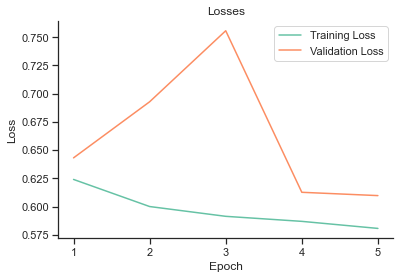

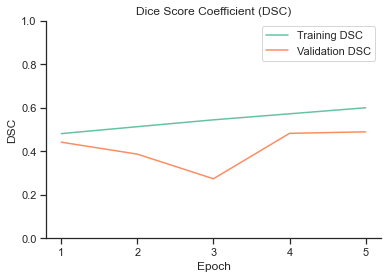

In [74]:
sns.set(font_scale=1)
sns.set_style("ticks")
sns.set_palette(sns.color_palette("Set2"))

plt.figure(0)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(train_losses) + 1), val_losses, label="Validation Loss")
plt.xticks(range(1, len(train_losses) + 1))
plt.legend()
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()
# plt.show()


# plt.clf()
plt.figure(1)
plt.plot(range(1, len(train_losses) + 1), train_accs, label="Training DSC")
plt.plot(range(1, len(train_losses) + 1), val_accs, label="Validation DSC")
plt.xticks(range(1, len(train_accs) + 1))
plt.ylim((0, 1))
plt.legend()
plt.title("Dice Score Coefficient (DSC)")
plt.xlabel("Epoch")
plt.ylabel("DSC")
sns.despine()

# plt.show()

Load trained model

In [12]:
trained_model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='batch',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
).to(device)
trained_model.load_state_dict(torch.load("./whole_images_best.pth"))
trained_model.eval()
optimizer = torch.optim.AdamW(trained_model.parameters(), lr=1e-3)

Test trained model on test set

In [83]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    num_workers=num_workers,
)

# test_loss = run_epoch(0, Action.VALIDATE, test_loader, model, optimizer)
test_loss, test_acc = test(test_loader, trained_model, optimizer)

  0%|          | 0/2 [00:00<?, ?it/s]

Testing mean loss: 0.06953 ± 0.00162
Testing mean accuracy: 0.93169 ± 0.00141


In [128]:
def rotate(image, radiological=True, n=-1):
    # Rotate for visualization purposes
    image = np.rot90(image, n)
    image = np.fliplr(image)
    return image

image = inputs[0]
data = image.data[-1].cpu()
indices = np.array(data.shape) // 2
i, j, k = indices

slice_x = rotate(data[i, :, :])
slice_y = rotate(data[:, j, :])
slice_z = rotate(data[:, :, k])


torch.Size([1, 256, 256, 128])
torch.Size([256, 256, 128])
[128 128  64]


In [43]:
from torchvision.utils import draw_segmentation_masks

Visualise predictions on test set

In [ ]:
def rotate(image, radiological=True, n=-1):
    # Rotate for visualization purposes
    image = np.rot90(image, n)
    image = np.fliplr(image)
    return image

generator = iter(test_loader)
i, j, k = [128, 128, 64]
sns.set_style("white")

for i in range(len(test_loader)):
    print("Segmenting image {0}".format(i+1))
    batch = next(generator)
    inputs, targets = prepare_batch(batch, device)    
    with torch.no_grad():
        probabilities = torch.sigmoid(trained_model(inputs)).cpu()
        predicted = (probabilities > threshold)

    print(inputs.shape)
    print(targets.shape)
    print(predicted.shape)
    
    input_slice = [rotate(inputs[i, :, :]), rotate(inputs[:, j, :]), rotate(inputs[:, :, k])]
    target_slice = [rotate(targets[i, :, :]), rotate(targets[:, j, :]), rotate(targets[:, :, k])]
    pred_slice = [rotate(predicted[i, :, :]), rotate(predicted[:, j, :]), rotate(predicted[:, :, k])]
    
    print("x: {0}".format(pred_slice[0].shape))
    print("y: {0}".format(pred_slice[1].shape))
    print("z: {0}".format(pred_slice[2].shape))

    dogs_with_masks = [
        draw_segmentation_masks(img, masks=mask, alpha=0.7)
        for img, mask in zip(input_slice, pred_slice)
    ]
    show(dogs_with_masks)
    
    break
    
    fig, axs = plt.subplots(ncols = 3)
    axs[0].imshow(input_slice[0])
    axs[0].set_title('CT')
    axs[1].imshow(input_slice[1])
    axs[1].set_title('CT')
    axs[2].imshow(input_slice[2])
    axs[2].set_title('CT')
    
    break
    
    
    cmap = plt.cm.get_cmap('tab10')
    ground_truth_masks = np.array([cmap(1 - x.cpu().numpy())[:, :, :, :3] for x in batch['label'][tio.DATA]])
    predicted_masks = np.array([cmap(1 - x.cpu().numpy())[:, :, :, :3] for x in predicted])

    
    print(batch['img'][tio.DATA].shape)
    print(batch['label'][tio.DATA].shape)
    print(ground_truth_masks.shape)
    print(predicted_masks.shape)
    
    overlay_images = np.concatenate([batch['img'][tio.DATA].numpy(), ground_truth_masks, predicted_masks], axis=3)

    # Reshape the overlay images to match the grid shape
    overlay_images = np.transpose(overlay_images, [0, 3, 1, 2])
    overlay_images = overlay_images.reshape(-1, 3, 100, 100)

    # Create a grid of images using Seaborn
    grid = sns.utils.grid.Grid(overlay_images, col_wrap=3)

    # Set the titles of the grid images
    for ax, title in zip(grid.axes, ['Original', 'Ground Truth', 'Predicted']):
        ax.set_title(title)

    # Remove the grid ticks and set the axis to be invisible
    grid.fig.subplots_adjust(wspace=0.1, hspace=0.1)
    grid.set(xticks=[], yticks=[])
    sns.despine(left=True, bottom=True)

    # Show the grid of images
    plt.show()
    
#     affine = batch['label'][tio.AFFINE][0].numpy()
#     subject = tio.Subject(
#         ct=tio.ScalarImage(tensor=batch['img'][tio.DATA][0], affine=affine),
#         truth=tio.LabelMap(tensor=batch['label'][tio.DATA][0], affine=affine),
#         predicted=tio.ScalarImage(tensor=(probabilities[0]), affine=affine),
#         predicted_binary= tio.LabelMap(tensor=(probabilities[0]>threshold), affine=affine)
#     )

#     score = get_dice_score((probabilities > threshold).float(), batch['label'][tio.DATA]).mean().item()
#     print("Dice score: {0:.5f}".format(score))
#     # subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})
#     subject.plot(figsize=(9, 8))



Segmenting image 1
(1, 256, 256, 128)
(2, 256, 256, 128)
(1, 256, 256, 128)
Dice score: 0.93027


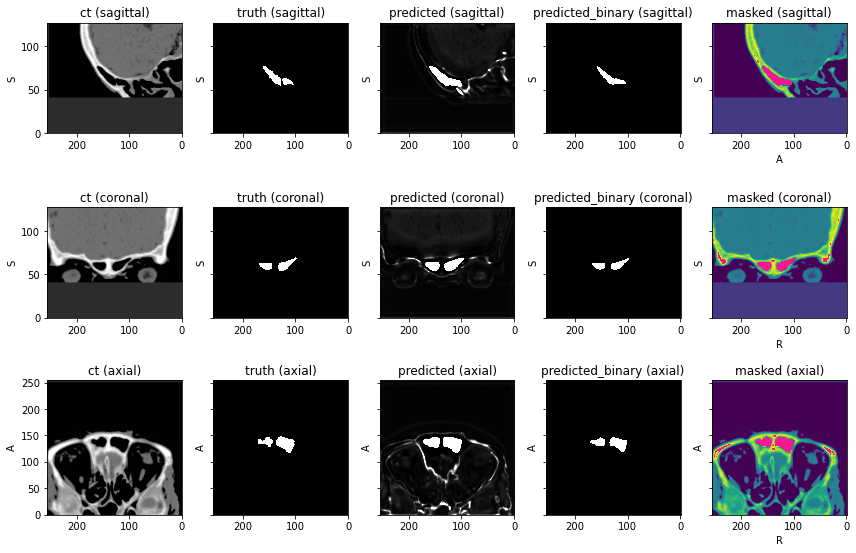

In [111]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    num_workers=num_workers,
)
generator = iter(test_loader)

viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[-1:, :] = pink
newcmp = ListedColormap(newcolors)

for i in range(len(test_loader)):
    print("Segmenting image {0}".format(i+1))
    batch = next(generator)
    inputs, targets = prepare_batch(batch, device)    
    FIRST = 0
    FOREGROUND = 1
    with torch.no_grad():
#         probabilities = trained_model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
#         probabilities = F.softmax(trained_model(inputs), dim=CHANNELS_DIMENSION)[:, FOREGROUND:].cpu()
        probabilities = torch.sigmoid(trained_model(inputs)).cpu()

    truth = torch.sum(batch['label'][tio.DATA][0], dim=0, keepdim=True)
    predicted_binary = (probabilities[0]>threshold).float()
    inverse_mask = 1 - predicted_binary
    affine = batch['label'][tio.AFFINE][0].numpy()
    
    subject = tio.Subject(
        ct=tio.ScalarImage(tensor=batch['img'][tio.DATA][0], affine=affine),
        truth=tio.LabelMap(tensor=batch['label'][tio.DATA][0], affine=affine),
#         truth2=tio.LabelMap(tensor=batch['label'][tio.DATA][0][0], affine=affine),
        predicted=tio.ScalarImage(tensor=(probabilities[0]), affine=affine),
        predicted_binary=tio.LabelMap(tensor=predicted_binary, affine=affine),
        predicted_inverse=tio.LabelMap(tensor=inverse_mask, affine=affine),
        inverse_mask=tio.LabelMap(tensor=torch.argmax(inverse_mask, dim=0, keepdim=True), affine=affine)
    )
    
    print(subject.ct.shape)
    print(subject.truth.shape)
    print(subject.inverse_mask.shape)
    
    mask = tio.Mask('inverse_mask', outside_value = 99)
    masked = mask(subject)
    subject.add_image(masked.ct, 'masked')
    
    subject.remove_image('predicted_inverse')
    subject.remove_image('inverse_mask')

    score = get_dice_score((probabilities > threshold).float(), batch['label'][tio.DATA]).mean().item()
    print("Dice score: {0:.5f}".format(score))
    subject.plot(figsize=(12, 8), cmap_dict={'masked': newcmp})
#     subject.plot(figsize=(12, 8))

    break


In [ ]:
for i, subject in enumerate(test_set.dry_iter()):
    subject['img'].save("./testset88/testimg{0}.nii".format(i+1))
    subject['label'].save("./testset88/testlabel{0}.nii".format(i+1))